<a href="https://colab.research.google.com/github/SandraFB/FD-Steel_Plates/blob/main/Faulty_steel_plates_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Evaluación técnica de candidatos - Científico de datos

## Objetivo:
Modela un clasificador sencillo en Python o R para  identificar el tipo de defecto que presenta el planchón.
## Datos de entrada: 
1. Un archivo TRAIN en formato tabla con 27 atributos/variables independientes, 7 clases/ variables dependientes y 1455 observaciones.
Las clases: 
* Pastry
* Z_Scratch
* K_Scatch
* Stains
* Dirtiness
* Bumps
* Other_Faults, 
son defectos que se encuentran en los planchones de acero. 
2. Un archivo TEST en formato tabla con  27 atributos/variables y 485 observaciones sobre las que se hará la clasificación de las variables faltantes. 

## Entregable: 
1. El archivo en formato tabla, con las clases concatenadas al final del archivo, siguiendo el formato del archivo TRAIN.
2. El código en R o Python con el que se obtuvo la clasificación, debidamente comentado. 
3. Adicionalmente, se pueden entregar visualizaciones del set de datos y de la solución propuesta, así como su justificación. 

```
"Fallas en planchones de acero"

Elaborado por Sandra de la Fuente
2021-08-21
Dudas: contacto@sandradelafuente.com
```



# Sección 1: Lectura de datos

In [1]:
######################################
#Carga de dataframe al cuadernillo
#Los archivos fueron cargados previamente a Google Drive en correo personal con la dirección 'My Drive/Colab Notebooks/Tecnoap/Evaluacion'
from google.colab import drive #La autenticación de la cuenta de google drive es necesaria. Para mayor información, consulte https://colab.research.google.com/notebooks/io.ipynb
drive.mount('/content/drive') #Se monta la carpeta raíz de Google Drive al cuadernillo de trabajo.
!cp "/content/drive/My Drive/Colab Notebooks/Tecnoap/Evaluacion/Faults.train" "Faults.train" #Se carga una copia del archivo "Faults.train" al espacio de trabajo.
!cp "/content/drive/My Drive/Colab Notebooks/Tecnoap/Evaluacion/Faults.test" "Faults.test" #Se carga una copia del archivo "Faults.test" al espacio de trabajo.
#######################################

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import warnings #Se importa la librería de notificaciones
warnings.filterwarnings('ignore') #Se omiten las notificaciones no relevantes en el código para hacer más amigable el código.
import rpy2.robjects as robjects #Se carga la paquetería de R para trabajar en R desde el entorno de Python 3, para este ejemplo.
%load_ext rpy2.ipython 

#Esta extensión nos permitirá establecer si queremos lenguaje R en la línea de código como "%%R"

In [3]:
%%R 
# %%R <- Lenguaje de la línea de código: R 
pkgs_Sec1 <- c('rsample', 'tidyverse', 'patchwork', 'skimr','caret', 'parsnip','dials','workflows','tune','knitr','yardstick','xgboost','dplyr')
install.packages(pkgs_Sec1)
library(rsample) 
library(tidyverse)
library(patchwork)
library(ggplot2)
library(skimr)
library(caret)
library(readr)
library(parsnip)
library(dials)
library(workflows)
library(tune)
library(knitr)
library(yardstick)
library(xgboost)
library(dplyr)

R[write to console]: Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: trying URL 'https://cran.rstudio.com/src/contrib/rsample_0.1.0.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 280155 bytes (273 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[wri

In [4]:
%%R 
# %%R <- Lenguaje de la línea de código: R
#Datos de entrenamiento
Faults_train <- read.table("Faults.train")
dim(Faults_train) #Se verifica que la información de entrenamiento se cargó adecuadamente. Las dimensiones del arreglo es de 1456 x 35
head(Faults_train) #Se considerará la fila 1 como header de la tabla en la línea siguiente porque actualmente se tiene otra información. Este cambio nos permitirá visualizar los datos con las leyendas adecuadas.
#Datos de prueba
Faults_test <- read.table("Faults.test")
dim(Faults_test)  #Se verifica que la información de entrenamiento se cargó adecuadamente. Las dimensiones del arreglo es de 486 x 28
head(Faults_test) #Se considerará la fila 1 como header de la tabla en la línea siguiente porque actualmente se tiene otra información. Este cambio nos permitirá visualizar los datos con las leyendas adecuadas.

  V1        V2        V3        V4        V5           V6          V7
1 NA X_Minimum X_Maximum Y_Minimum Y_Maximum Pixels_Areas X_Perimeter
2  2       829       835   1553913   1553931           71           8
3  4      1289      1306    498078    498335         2409          60
4  6       413       446    138468    138883         9052         230
5  9        74        90    779144    779308         1506          46
6 12        46        58    179258    179312          480          15
           V8                V9                   V10                   V11
1 Y_Perimeter Sum_of_Luminosity Minimum_of_Luminosity Maximum_of_Luminosity
2          19              7972                    99                   125
3         260            246930                    37                   126
4         432           1481991                    23                   199
5         167            180215                    53                   143
6          54             61966                   102 

# Sección 2. EDA

In [5]:
%%R 
names(Faults_train) <- as.matrix(Faults_train[1, ]) #Se nombra los encabezados de cada columna de la tabla de entrenamiento con la etiqueta de la fila 1.
Faults_train <- Faults_train[-1, ] #Se elimina la fila 1 de la tabla (pues corresponde a las etiquetas que ahora están en los encabezados).
names(Faults_train)[1] <- 'id'#Renombrando la primera columna como identificador de muestra. 
Faults_train[] <- lapply(Faults_train, function(x) type.convert(as.character(x))) #Convierte las variables en caracteres.
head(Faults_train) #Muesta las primeras filas de la tabla de entrenamiento.

names(Faults_test) <- as.matrix(Faults_test[1, ])  #Se nombra los encabezados de cada columna de la tabla de entrenamiento con la etiqueta de la fila 1.
Faults_test <- Faults_test[-1, ] #Se elimina la fila 1 de la tabla (pues corresponde a las etiquetas que ahora están en los encabezados).
names(Faults_test)[1] <- 'id' #Renombrando la primera columna como identificador de muestra.
Faults_test[] <- lapply(Faults_test, function(x) type.convert(as.character(x))) 
head(Faults_test)  #Muesta las primeras filas de la tabla de prueba.

  id X_Minimum X_Maximum Y_Minimum Y_Maximum Pixels_Areas X_Perimeter
2  2       829       835   1553913   1553931           71           8
3  4      1289      1306    498078    498335         2409          60
4  6       413       446    138468    138883         9052         230
5  9        74        90    779144    779308         1506          46
6 12        46        58    179258    179312          480          15
7 18        82        89    844704    844729          137           8
  Y_Perimeter Sum_of_Luminosity Minimum_of_Luminosity Maximum_of_Luminosity
2          19              7972                    99                   125
3         260            246930                    37                   126
4         432           1481991                    23                   199
5         167            180215                    53                   143
6          54             61966                   102                   158
7          25             14907                    92 

In [6]:
%%R 
#A continuación se mezclan las bases de datos para verificar la singularidad del id de la muestra
Faults_db <- full_join(Faults_train, Faults_test) 
n_occur <- data.frame(table(Faults_db$id))
Faults_db[Faults_db$id %in% n_occur$Var1[n_occur$Freq > 1],] #Se verifica que no existan id's repetidos. Los datos tienen el id auténtico y no hay repeticiones, por lo cual se considera mantener en ambas bases de datos.
#colnames(Faults_train) #Se muestra el nombre de las columnas de la tabla de entrenamiento.

Joining, by = c("id", "X_Minimum", "X_Maximum", "Y_Minimum", "Y_Maximum", "Pixels_Areas", "X_Perimeter", "Y_Perimeter", "Sum_of_Luminosity", "Minimum_of_Luminosity", "Maximum_of_Luminosity", "Length_of_Conveyer", "TypeOfSteel_A300", "TypeOfSteel_A400", "Steel_Plate_Thickness", "Edges_Index", "Empty_Index", "Square_Index", "Outside_X_Index", "Edges_X_Index", "Edges_Y_Index", "Outside_Global_Index", "LogOfAreas", "Log_X_Index", "Log_Y_Index", "Orientation_Index", "Luminosity_Index", "SigmoidOfAreas")
 [1] id                    X_Minimum             X_Maximum            
 [4] Y_Minimum             Y_Maximum             Pixels_Areas         
 [7] X_Perimeter           Y_Perimeter           Sum_of_Luminosity    
[10] Minimum_of_Luminosity Maximum_of_Luminosity Length_of_Conveyer   
[13] TypeOfSteel_A300      TypeOfSteel_A400      Steel_Plate_Thickness
[16] Edges_Index           Empty_Index           Square_Index         
[19] Outside_X_Index       Edges_X_Index         Edges_Y_Index        

In [7]:
%%R
var_train <- as.data.frame.matrix(Faults_train[,(2:28)]) #Adaptamos la tabla "Variables de entrada" como "var_train" 
class_train <- as.data.frame.matrix(Faults_train[,-(1:28)]) #Adaptamos la tabla de clases como "class_train"
summary(class_train)

     Pastry         Z_Scratch          K_Scatch          Stains       
 Min.   :0.0000   Min.   :0.00000   Min.   :0.0000   Min.   :0.00000  
 1st Qu.:0.0000   1st Qu.:0.00000   1st Qu.:0.0000   1st Qu.:0.00000  
 Median :0.0000   Median :0.00000   Median :0.0000   Median :0.00000  
 Mean   :0.0811   Mean   :0.09966   Mean   :0.2021   Mean   :0.03711  
 3rd Qu.:0.0000   3rd Qu.:0.00000   3rd Qu.:0.0000   3rd Qu.:0.00000  
 Max.   :1.0000   Max.   :1.00000   Max.   :1.0000   Max.   :1.00000  
   Dirtiness           Bumps         Other_Faults   
 Min.   :0.00000   Min.   :0.0000   Min.   :0.0000  
 1st Qu.:0.00000   1st Qu.:0.0000   1st Qu.:0.0000  
 Median :0.00000   Median :0.0000   Median :0.0000  
 Mean   :0.02887   Mean   :0.2076   Mean   :0.3436  
 3rd Qu.:0.00000   3rd Qu.:0.0000   3rd Qu.:1.0000  
 Max.   :1.00000   Max.   :1.0000   Max.   :1.0000  


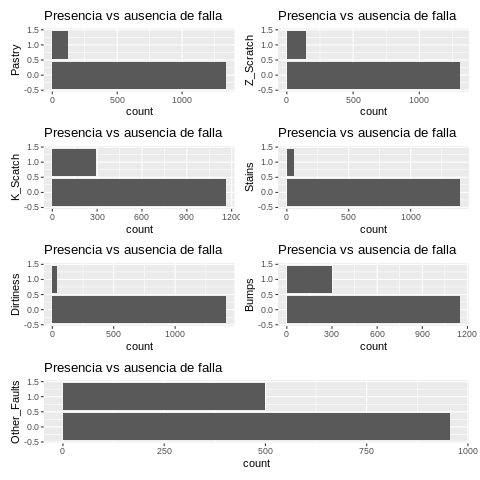

In [8]:
%%R
# Se grafica cada clase para mostrar el número de eventos con fallas detectadas en el experimento 
g0 <- ggplot(class_train, aes(y=Pastry)) + geom_bar() + labs(title = "Presencia vs ausencia de falla")  
g1 <- ggplot(class_train, aes(y=Z_Scratch)) + geom_bar() + labs(title = "Presencia vs ausencia de falla") 
g2 <- ggplot(class_train, aes(y=K_Scatch)) + geom_bar() + labs(title = "Presencia vs ausencia de falla") 
g3 <- ggplot(class_train, aes(y=Stains)) + geom_bar() + labs(title = "Presencia vs ausencia de falla") 
g4 <- ggplot(class_train, aes(y=Dirtiness)) + geom_bar()+ labs(title = "Presencia vs ausencia de falla") 
g5 <- ggplot(class_train, aes(y=Bumps)) + geom_bar() + labs(title = "Presencia vs ausencia de falla") 
g6 <- ggplot(class_train, aes(y=Other_Faults)) + geom_bar()+ labs(title = "Presencia vs ausencia de falla") 

(g0 | g1) / (g2 |g3 )/(g4 | g5) /
g6 #Exhibición y acomodo de gráficas

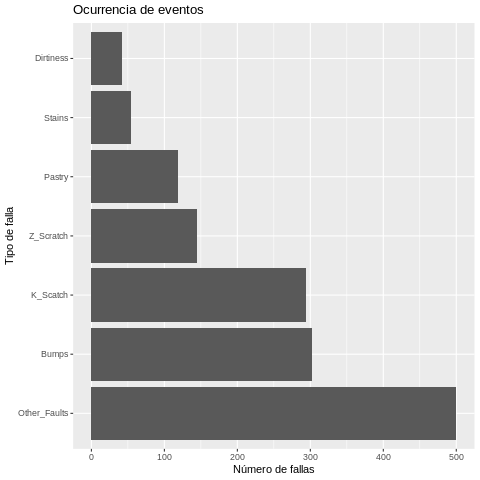

In [9]:
%%R
# Se grafica de forma ordenada el número de eventos presentes en la muestra, por cada clase. 
df <- data.frame(class_train)
df %>%
    gather(season,count) %>%
    filter(count > 0) %>%
    ggplot(aes(forcats::fct_infreq(season))) +
        geom_bar() + coord_flip() + labs(title = "Ocurrencia de eventos", x = "Tipo de falla", y = "Número de fallas")

In [10]:
%%R
# Impresión del nombres de las variables
names(Faults_test)

 [1] "id"                    "X_Minimum"             "X_Maximum"            
 [4] "Y_Minimum"             "Y_Maximum"             "Pixels_Areas"         
 [7] "X_Perimeter"           "Y_Perimeter"           "Sum_of_Luminosity"    
[10] "Minimum_of_Luminosity" "Maximum_of_Luminosity" "Length_of_Conveyer"   
[13] "TypeOfSteel_A300"      "TypeOfSteel_A400"      "Steel_Plate_Thickness"
[16] "Edges_Index"           "Empty_Index"           "Square_Index"         
[19] "Outside_X_Index"       "Edges_X_Index"         "Edges_Y_Index"        
[22] "Outside_Global_Index"  "LogOfAreas"            "Log_X_Index"          
[25] "Log_Y_Index"           "Orientation_Index"     "Luminosity_Index"     
[28] "SigmoidOfAreas"       


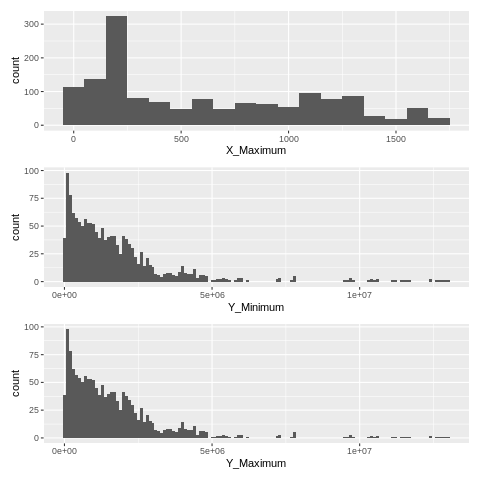

In [11]:
%%R
#Histograma
#En las siguientes líneas de código, se grafican los histogramas de las variables para identificar oportunidades de mejora en el preprocesamiento de los datos.
q1 <-  ggplot(Faults_train, aes(X_Maximum)) +
  geom_histogram(binwidth = 100)
q2 <-  ggplot(Faults_train, aes(Y_Minimum)) +
  geom_histogram(binwidth = 100000)
q3 <-  ggplot(Faults_train, aes(Y_Maximum)) +
  geom_histogram(binwidth = 100000)

q1 / q2 / q3

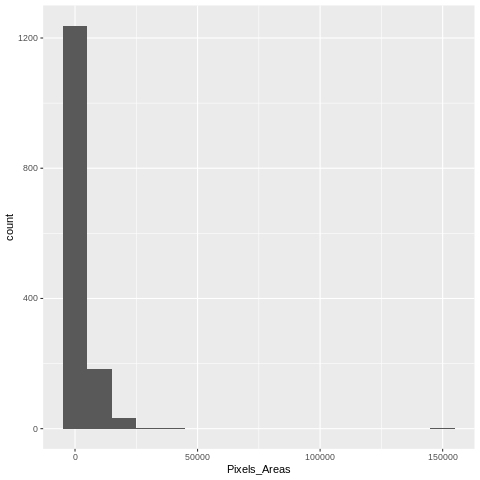

In [12]:
%%R
q4 <- ggplot(Faults_train, aes(Pixels_Areas)) +
  geom_histogram(binwidth = 10000)
q4

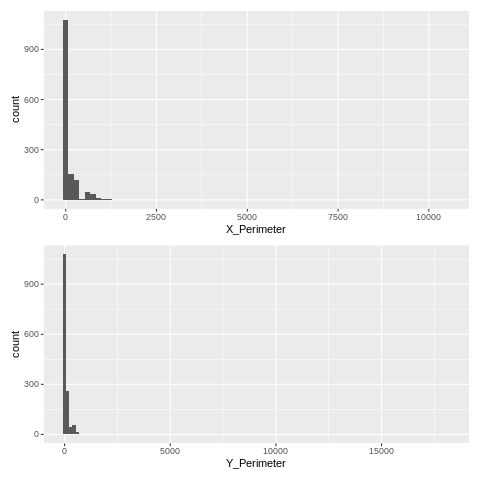

In [13]:
%%R
q5 <- ggplot(Faults_train, aes(X_Perimeter)) +
  geom_histogram(binwidth = 150)
q6 <- ggplot(Faults_train, aes(Y_Perimeter)) +
  geom_histogram(binwidth = 150)
q5 / q6

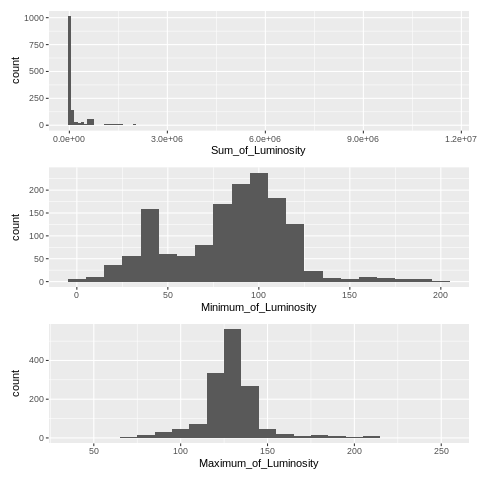

In [14]:
%%R
q7 <- ggplot(Faults_train, aes(Sum_of_Luminosity)) +
  geom_histogram(binwidth = 100000)
q8 <- ggplot(Faults_train, aes(Minimum_of_Luminosity)) +
  geom_histogram(binwidth = 10)
q9 <- ggplot(Faults_train, aes(Maximum_of_Luminosity)) +
  geom_histogram(binwidth = 10)
q7/q8/q9

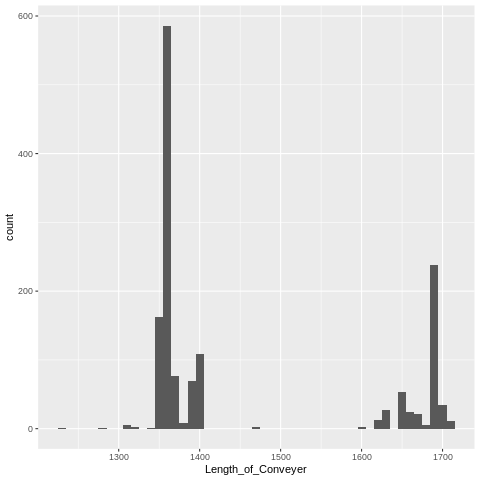

In [15]:
%%R
q10 <- ggplot(Faults_train, aes(Length_of_Conveyer)) +
  geom_histogram(binwidth = 10)
q10

R[write to console]: `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



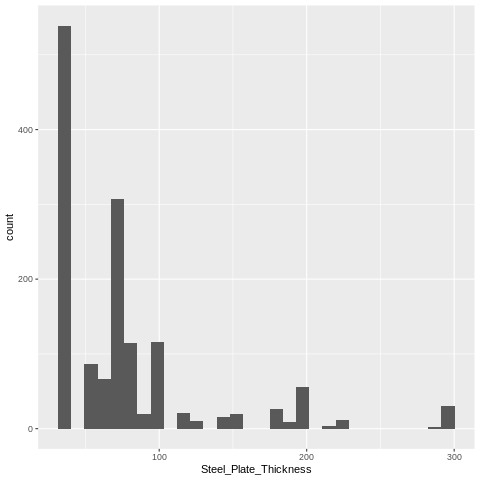

In [16]:
%%R
q11 <- ggplot(Faults_train, aes(Steel_Plate_Thickness)) +
  geom_histogram()
q11

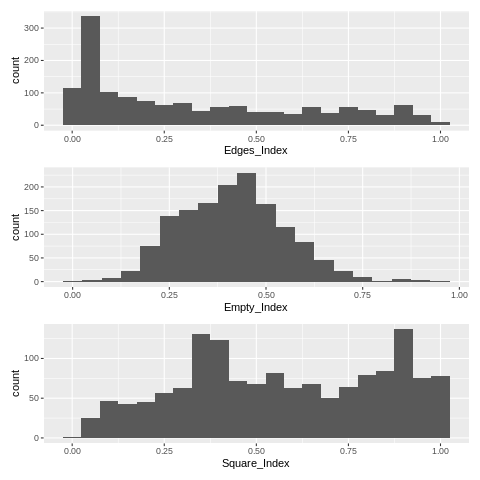

In [17]:
%%R
q12 <- ggplot(Faults_train, aes(Edges_Index)) +
  geom_histogram(binwidth = 0.05)
q13 <- ggplot(Faults_train, aes(Empty_Index)) +
  geom_histogram(binwidth = 0.05)
q14 <- ggplot(Faults_train, aes(Square_Index)) +
  geom_histogram(binwidth = 0.05)
q12/q13/q14

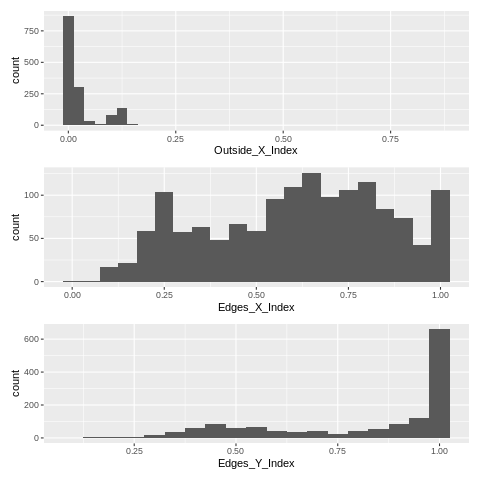

In [18]:
%%R
q15 <- ggplot(Faults_train, aes(Outside_X_Index)) +
  geom_histogram(binwidth = 0.025)
q16 <- ggplot(Faults_train, aes(Edges_X_Index)) +
  geom_histogram(binwidth = 0.05)
q17 <- ggplot(Faults_train, aes(Edges_Y_Index)) +
  geom_histogram(binwidth = 0.05)
q15/q16/q17

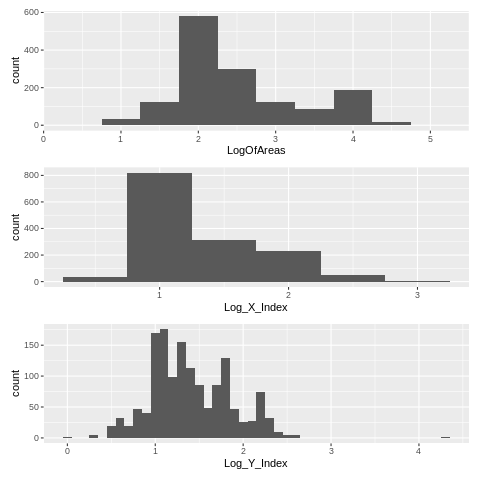

In [19]:
%%R
q18 <- ggplot(Faults_train, aes(LogOfAreas)) +
  geom_histogram(binwidth = 0.5)
q19 <- ggplot(Faults_train, aes(Log_X_Index)) +
  geom_histogram(binwidth = 0.5)
q20 <- ggplot(Faults_train, aes(Log_Y_Index)) +
  geom_histogram(binwidth = .1)
q18/q19/q20

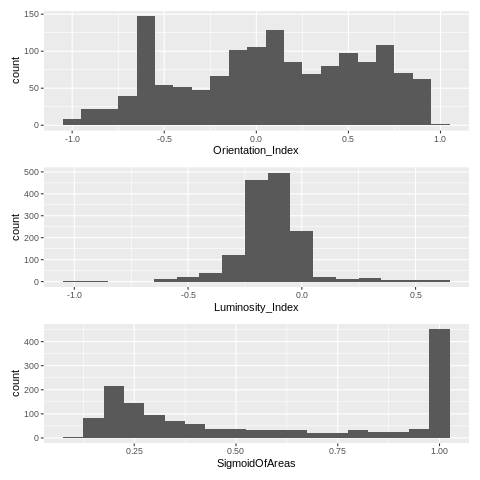

In [20]:
%%R
q21 <- ggplot(Faults_train, aes(Orientation_Index)) +
  geom_histogram(binwidth = 0.1)
q22 <- ggplot(Faults_train, aes(Luminosity_Index)) +
  geom_histogram(binwidth = 0.1)
q23 <- ggplot(Faults_train, aes(SigmoidOfAreas)) +
  geom_histogram(binwidth = 0.05)
q21/q22/q23

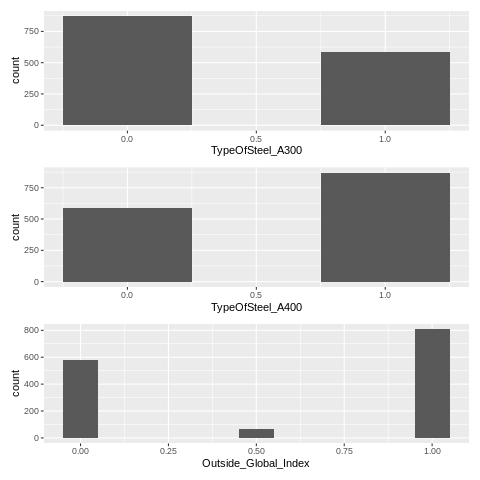

In [21]:
%%R
q24 <- ggplot(Faults_train, aes(TypeOfSteel_A300)) +
  geom_histogram(binwidth = 0.5)
q25 <- ggplot(Faults_train, aes(TypeOfSteel_A400)) +
  geom_histogram(binwidth = 0.5)
q26 <- ggplot(Faults_train, aes(Outside_Global_Index)) +
  geom_histogram(binwidth = 0.1)
q24/q25/q26

In [22]:
%%R
#Debido a que se mostró una amplia variación en las escalas de las variables, escalaremos los valores y revisaremos el resultado resumido 
skimmed <- skim(var_train)
skimmed

── Data Summary ────────────────────────
                           Values   
Name                       var_train
Number of rows             1455     
Number of columns          27       
_______________________             
Column type frequency:              
  numeric                  27       
________________________            
Group variables            None     

── Variable type: numeric ──────────────────────────────────────────────────────
   skim_variable         n_missing complete_rate         mean           sd
 1 X_Minimum                     0             1     570.         517.    
 2 X_Maximum                     0             1     616.         494.    
 3 Y_Minimum                     0             1 1676894.     1826262.    
 4 Y_Maximum                     0             1 1676950.     1826278.    
 5 Pixels_Areas                  0             1    1908.        5541.    
 6 X_Perimeter                   0             1     114.         331.    
 7 Y_Perimeter     

In [23]:
%%R
#Se observa que el escalamiento es necesario, esto permitirá que el modelo sea más exacto.
scale <- preProcess(var_train, method='scale')
scaled_var_train <- predict(scale, newdata = var_train)
skimmed_transformed <- skim(scaled_var_train)
skimmed_transformed

── Data Summary ────────────────────────
                           Values          
Name                       scaled_var_train
Number of rows             1455            
Number of columns          27              
_______________________                    
Column type frequency:                     
  numeric                  27              
________________________                   
Group variables            None            

── Variable type: numeric ──────────────────────────────────────────────────────
   skim_variable         n_missing complete_rate   mean    sd        p0     p25
 1 X_Minimum                     0             1  1.10      1  0         0.108 
 2 X_Maximum                     0             1  1.25      1  0.00810   0.393 
 3 Y_Minimum                     0             1  0.918     1  0.00368   0.275 
 4 Y_Maximum                     0             1  0.918     1  0.00368   0.275 
 5 Pixels_Areas                  0             1  0.344     1  0.000361  0.0149
 

In [24]:
%%R
#Se agrega la referencia "Fault" al conjunto de entrenamiento, corresponde al outcome nominal de las etiquetas de las clases. 
train_db <- as.data.frame.matrix(Faults_train) 
train_db <- train_db %>% add_column(Fault = 0)
train_db$Fault[which(train_db$Pastry == 1)] = "Pastry"
train_db$Fault[which(train_db$Z_Scratch == 1)] = "Z_Scratch"
train_db$Fault[which(train_db$K_Scatch == 1)] = "K_Scatch"
train_db$Fault[which(train_db$Stains == 1)] = "Stains"
train_db$Fault[which(train_db$Dirtiness == 1)] = "Dirtiness"
train_db$Fault[which(train_db$Bumps == 1)] = "Bumps"
train_db$Fault[which(train_db$Other_Faults == 1)] = "Other"

#Datos de prueba
fd_train <- train_db[,-(29:35)]
#fd_data <- as.data.frame.data.frame(fd_train)
fd_split <- rsample::initial_split(fd_train, prop = 0.2)

#Datos de entrenamiento
test_db <- as.data.frame.matrix(Faults_test) 
test_db <- test_db %>% add_column(Fault = 0)
fd_test <- test_db

# Sección 3: Preprocesamiento

In [25]:
%%R
#La receta prepara los datos para el modelo del clasificador. La paquetería "recipes" de Tidymodels simplifica las líneas de código y, haciendo buen uso, optimiza el resultado.
library(recipes)

### Variables modificadas
fd_recipe <- 
  recipes::recipe(Fault ~ ., data=fd_train) %>% #Definimos "Fault" como nuestra variable dependiente.
  recipes::step_string2factor(all_nominal()) %>% #Convierte las variables categóricas a factores.
  recipes::step_dummy(all_nominal_predictors(),-all_outcomes()) %>% #Para variables categóricas independientes, únicamente.
  recipes::step_rm(id) %>% #Elimina las columnas de las variables independientes, pues la información que ocuparemos está en la variable "Fault".
  recipes::step_scale(all_predictors(), -all_outcomes()) %>% #Escala las variables de entrada como en el ejemplo anterior, visualizado con skimr. Sólamente funciona para las variables independientes.
  recipes::step_zv(all_numeric(), -all_outcomes()) %>% #Elimina variables con desviación estándar nula.
  recipes::step_corr(all_predictors(), threshold = 0.7, method = "spearman")%>% #Elimina variables que tienen correlación muy alta con otras variables.
  prep()

save(fd_recipe, file = "receta.RData") #Guarda la receta 

variables <- summary(fd_recipe) #Muestra el tipo de variable, rol y origen en la receta
variables
#Puede notar que nuestro groundtruth es la variable "Fault" y las demás variables independientes. 

R[write to console]: 
Attaching package: ‘recipes’


R[write to console]: The following object is masked from ‘package:stringr’:

    fixed


R[write to console]: The following object is masked from ‘package:stats’:

    step




# A tibble: 13 × 4
   variable              type    role      source  
   <chr>                 <chr>   <chr>     <chr>   
 1 X_Maximum             numeric predictor original
 2 Y_Minimum             numeric predictor original
 3 Maximum_of_Luminosity numeric predictor original
 4 Length_of_Conveyer    numeric predictor original
 5 TypeOfSteel_A400      numeric predictor original
 6 Steel_Plate_Thickness numeric predictor original
 7 Edges_Index           numeric predictor original
 8 Empty_Index           numeric predictor original
 9 Square_Index          numeric predictor original
10 Edges_X_Index         numeric predictor original
11 Edges_Y_Index         numeric predictor original
12 Outside_Global_Index  numeric predictor original
13 Fault                 nominal outcome   original


# Sección 4. Definición de modelo

## Sección 4.1 Cross Validation.

In [26]:
%%R
library(rsample)
#Se aplica la receta a nuestros datos de entrenamiento y un split aleatorio de 5 conjuntos en los datos de entrenamiento. Utilizaremos estos conjuntos en las siguientes líneas para medir el desempeño de modelos y posteriormente compararlos.

fd_cv <-
  recipes::bake(fd_recipe,
                 new_data= training(
                   fd_split)) %>%
  rsample::vfold_cv(v=5)

#Los datos en este punto, ya se encuentran ordenados y listos para ser utilizados en los modelos.

## Sección 4.2. Modelos

In [27]:
%%R
#Se definen modelos

#1. Random Forest puede ser una buena opción de inicio, revisaremos el resultado
rf_model <- 
  parsnip::rand_forest(
    trees=1000, 
    mode="classification" )%>%
  set_engine("ranger", importance = "impurity")

#2. Otra alternativa de interés para este ejercicio es KNN, vamos a probarlo
knn_model <- 
  parsnip::nearest_neighbor(
    neighbors = 4,
    mode="classification") %>%  
  set_engine("kknn")

##3. Otro enfoque interesante y que me ha dado buenos resultados antes para este tipo de problemas, es utilizar Boosted Trees. Comparemos el resultado.
xgb_model <- 
  parsnip::boost_tree(
    trees=1000,
    mode= "classification")%>%
  set_engine("xgboost")

##4. Evaluamos el desempeño de un XBoost con hiperparámetros optimizados
xgbt_model <- 
  parsnip::boost_tree( mode="classification",
    trees = tune(), tree_depth = tune(), min_n = tune(),
    loss_reduction = tune(),sample_size = tune(), 
    mtry = tune(),learn_rate = tune()) %>%  
  set_engine("xgboost")

## Sección 4.3. Combinaciones de parámetros para modelo optimizado

In [28]:
%%R 
#Se especifican las reglas a través de las cuales se llevará a cabo la optimización del modelo.

#Se definen las reglas para la optimización. Se establecerá el número de interacciones, el número mínimo de datos y la cantidad de splits requeridos y la reducción en el loss function. También se define el learning rate o eta.
xgbt_params <-
  dials::parameters(
    trees(),min_n(), tree_depth(), learn_rate(), loss_reduction(),finalize( mtry(), fd_train[,-1]), sample_size = sample_prop()) #Parámetros a optimizar

set.seed(283)
xgbt_grid <-
  dials::grid_latin_hypercube(xgbt_params, size=60) 

knitr::kable(head(xgbt_grid))



| trees| min_n| tree_depth| learn_rate| loss_reduction| mtry| sample_size|
|-----:|-----:|----------:|----------:|--------------:|----:|-----------:|
|  1829|    31|          6|  0.0000000|     20.6722140|   21|   0.7173468|
|   896|    25|         12|  0.0006505|      2.5751489|   24|   0.2040957|
|   790|     6|          9|  0.0000000|      0.0398245|   20|   0.6021863|
|  1871|     3|          8|  0.0000149|      0.0000002|   15|   0.9270823|
|  1857|    32|          3|  0.0043138|      0.0000013|   28|   0.2935573|
|   358|    15|          8|  0.0017379|      0.0000000|   10|   0.7823610|


## Sección 4.4. Workflow

In [29]:
%%R
library(workflows)

## Agregaremos un Workflow que contenga nuestro modelo y la fórmula

#1. Para el modelo de Random Forest:
rf_wf <- 
  workflows::workflow() %>%
  add_model(rf_model) %>%
  add_formula(Fault~.)

#2. Para el modelo de KNN:
knn_wf <- 
  workflows::workflow() %>%
  add_model(knn_model) %>%
  add_formula(Fault~.)

#3. Para el modelo de XGB:
xgb_wf <- 
  workflows::workflow() %>%
  add_model(xgb_model) %>%
  add_formula(Fault~.)

#4. Para el modelo de XGB optimizado:
xgbt_wf <- 
  workflows::workflow() %>%
  add_model(xgbt_model) %>%
  add_formula(Fault~.)

---------
Se realiza el ejercicio con el modelo XBoost Tree utilizando hiperparámetros optimizados. Se opta por esta elección debido a que se puede visualizar un mayor alcance con este método. Para los modelos 1 al 3, se pueden realizar los mismos pasos, evitando la optimización de parámetros. 

## Sección 4.5. Optimización de modelo XGBoost Tree

*Sección* 4.5.1 Evaluación de XGBoost optimizado

> Durante la optimización del modelo XGBoost Tree, especificamos 60 diferentes combinaciones de parámetros y 5 folds de los datos de entrenamiento originales, estimando las métricas de evaluación:

* Recall,
* Exactitud y
* F-score

> Este modelo se ajustó a 300 modelos XGBoost. Aunque puede parecer demasiados recursos para el enfoque que estamos estudiando en el ejemplo. Sin embargo, se deseaba mostrar los alcances de la optimización de modelos de clasificación sencillos.

La pregunta en este ejercicio de optimización es, ¿con qué modelo de los 150 obtenidos nos quedamos? Para decidirlo, deberemos establecer la métrica de referencia. 



In [30]:
%%R
#Optimizamos el modelo 4
xgbt_tuned<-
  tune::tune_grid(
    object=xgbt_wf,
    resamples= fd_cv,
    grid= xgbt_grid, 
    metrics= yardstick::metric_set(recall, f_meas, accuracy), # Definimos las méticas de evaluación
    control= tune::control_grid(verbose=TRUE)
  )

R[write to console]: i Fold1: preprocessor 1/1

R[write to console]: ✓ Fold1: preprocessor 1/1

R[write to console]: i Fold1: preprocessor 1/1, model 1/60

R[write to console]: ✓ Fold1: preprocessor 1/1, model 1/60

R[write to console]: i Fold1: preprocessor 1/1, model 1/60 (predictions)

R[write to console]: i Fold1: preprocessor 1/1, model 2/60

R[write to console]: ✓ Fold1: preprocessor 1/1, model 2/60

R[write to console]: i Fold1: preprocessor 1/1, model 2/60 (predictions)

R[write to console]: i Fold1: preprocessor 1/1, model 3/60

R[write to console]: ✓ Fold1: preprocessor 1/1, model 3/60

R[write to console]: i Fold1: preprocessor 1/1, model 3/60 (predictions)

R[write to console]: i Fold1: preprocessor 1/1, model 4/60

R[write to console]: ✓ Fold1: preprocessor 1/1, model 4/60

R[write to console]: i Fold1: preprocessor 1/1, model 4/60 (predictions)

R[write to console]: i Fold1: preprocessor 1/1, model 5/60

R[write to console]: ✓ Fold1: preprocessor 1/1, model 5/60

R[write 

In [31]:
%%R
#Considerando que nos interesa detectar "todas" las fallas en los planchones, eligiré recall como la métrica de referencia. Para que no se nos escapen detecciones.

xgbt_tuned %>% 
  tune::show_best(metric="recall") %>%
  knitr::kable()



| mtry| trees| min_n| tree_depth| learn_rate| loss_reduction| sample_size|.metric |.estimator |      mean|  n|   std_err|.config               |
|----:|-----:|-----:|----------:|----------:|--------------:|-----------:|:-------|:----------|---------:|--:|---------:|:---------------------|
|    2|   911|     9|         14|  0.0876219|       0.00e+00|   0.9555168|recall  |macro      | 0.5052572|  5| 0.0383678|Preprocessor1_Model12 |
|   27|   223|     2|         13|  0.0143386|       2.70e-06|   0.5080715|recall  |macro      | 0.5000587|  5| 0.0533305|Preprocessor1_Model01 |
|    4|  1542|     8|          1|  0.0372752|       0.00e+00|   0.7139642|recall  |macro      | 0.4763948|  5| 0.0318902|Preprocessor1_Model09 |
|   15|  1871|     3|          8|  0.0000149|       2.00e-07|   0.9270823|recall  |macro      | 0.4277486|  5| 0.0397965|Preprocessor1_Model02 |
|   22|   655|     4|          9|  0.0000013|       4.95e-04|   0.4835284|recall  |macro      | 0.4266775|  5| 0.0489630|Preproc

In [32]:
%%R
#Mostramos los valores de los hiperparámetros que mejor se desempeñaron en la prueba
xgbt_best_params <-
  xgbt_tuned %>%
  tune::select_best("recall")
knitr::kable(xgbt_best_params)



| mtry| trees| min_n| tree_depth| learn_rate| loss_reduction| sample_size|.config               |
|----:|-----:|-----:|----------:|----------:|--------------:|-----------:|:---------------------|
|    2|   911|     9|         14|  0.0876219|              0|   0.9555168|Preprocessor1_Model12 |


In [33]:
%%R
#Mejor modelo optimizado
xgbt_model_b <- 
  xgbt_model %>% 
  finalize_model(xgbt_best_params)

## Sección 5. Evaluación del modelo en base de datos

In [34]:
%%R
#Evaluación del modelo optimizado en base de datos de entrenamiento
train_proc <-
  recipes::bake(fd_recipe,
                new_data= training(fd_split))

#Predecimos la clase de la falla en el subconjunto de entrenamiento, con los datos ya preprocesados por nuestra receta. Omitimos celdas aleatorias para acercarnos a un caso real.

train_pred <-
  xgbt_model_b %>%
  fit(
    formula= Fault~.,
    data= train_proc)%>%
  predict(new_data= train_proc) %>%
  bind_cols(training(fd_split))

#Evaluamos el desempeño de nuestro ejercicio
knitr::kable(train_pred)

[06:20:15] WARNING: amalgamation/../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


|     |.pred_class |   id| X_Minimum| X_Maximum| Y_Minimum| Y_Maximum| Pixels_Areas| X_Perimeter| Y_Perimeter| Sum_of_Luminosity| Minimum_of_Luminosity| Maximum_of_Luminosity| Length_of_Conveyer| TypeOfSteel_A300| TypeOfSteel_A400| Steel_Plate_Thickness| Edges_Index| Empty_Index| Square_Index| Outside_X_Index| Edges_X_Index| Edges_Y_Index| Outside_Global_Index| LogOfAreas| Log_X_Index| Log_Y_Index| Orientation_Index| Luminosity_Index| SigmoidOfAreas|Fault     |
|:----|:-----------|----:|---------:|---------:|---------:|---------:|------------:|-----------:|-----------:|-----------------:|---------------------:|---------------------:|------------------:|----------------:|----------------:|---------------------:|-----------:

In [35]:
%%R
library(mltools)
library(data.table)

train_new <- as.data.table(train_pred)

names(train_new)[names(train_new)== ".pred_class"]<- "Pred"

dim(train_new)

R[write to console]: 
Attaching package: ‘mltools’


R[write to console]: The following objects are masked from ‘package:yardstick’:

    mcc, rmse


R[write to console]: The following object is masked from ‘package:tidyr’:

    replace_na


R[write to console]: data.table 1.14.0 using 1 threads (see ?getDTthreads).  Latest news: r-datatable.com

R[write to console]: 
Attaching package: ‘data.table’


R[write to console]: The following object is masked from ‘package:rlang’:

    :=


R[write to console]: The following objects are masked from ‘package:dplyr’:

    between, first, last


R[write to console]: The following object is masked from ‘package:purrr’:

    transpose




[1] 291  30


In [36]:
%%R
# Convertimos los valores de la predicción a caracteres
train_new2 <- data.frame(lapply(train_new, as.character), stringsAsFactors=FALSE)
train_new2 <- train_new2[,c(2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,1)]
head(train_new2)

write_csv(train_new2, "Prueba_entrenamiento.csv")

In [37]:
#Con objetivo de simplificar el código, desde python imprimimos la matriz de confusión de la prueba de entrenamiento (la cual fue solo un ejemplo para evaluar el desempeño)
#Recordemos que durante esta prueba, se bloquearon celdas aleatoriamente para reducir overfitting.

import numpy as np
import pandas as pd
from sklearn import metrics

input_file = "Prueba_entrenamiento.csv"

df = pd.read_csv(input_file, header = 0)
x = df["Fault"]
y = df["Pred"]

print(metrics.confusion_matrix(x,y))

[[ 66   0   0   0   1   0   0]
 [  2   2   0   1   1   0   0]
 [  0   0  58   0   0   0   0]
 [  0   0   1 104   0   0   0]
 [  0   0   0   2  20   0   0]
 [  1   0   0   0   0   5   0]
 [  1   0   0   0   0   0  26]]


In [38]:
# Estimamos las métricas de desempeño del modelo en la prueba de entrenamiento
print(metrics.classification_report(x,y))

              precision    recall  f1-score   support

       Bumps       0.94      0.99      0.96        67
   Dirtiness       1.00      0.33      0.50         6
    K_Scatch       0.98      1.00      0.99        58
       Other       0.97      0.99      0.98       105
      Pastry       0.91      0.91      0.91        22
      Stains       1.00      0.83      0.91         6
   Z_Scratch       1.00      0.96      0.98        27

    accuracy                           0.97       291
   macro avg       0.97      0.86      0.89       291
weighted avg       0.97      0.97      0.96       291



## Evaluación en conjunto de prueba

In [39]:
%%R
#Evaluación del modelo optimizado en base de datos de prueba
test_proc <-
  recipes::bake(fd_recipe,
                new_data= fd_test)
  
ref_proc <- 
  recipes::bake(fd_recipe,
                new_data= fd_train)
  
#Se estima la probabilidad de cada posible clasificación en el conjunto de prueba.
xgbt_test <- xgbt_model_b %>%
  fit(Fault~., data = ref_proc) 

final_pred <- predict(xgbt_test, test_proc,type = "prob")

[06:20:19] WARNING: amalgamation/../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [40]:
%%R
library(dplyr)

glimpse(final_pred) # La probabilidad de predicción nos permite darnos una idea del desempeño del modelo en el conjunto de prueba. 
#Debido a que no se tiene groundtruth, no tenemos un valor de referencia para estimar las métricas de evaluación como en el ejemplo de entrenamiento.

Rows: 485
Columns: 7
$ .pred_Bumps     <dbl> 0.1294610649, 0.0144992294, 0.0012556717, 0.0015154104…
$ .pred_Dirtiness <dbl> 0.0335057527, 0.0223861374, 0.0303326473, 0.0086005125…
$ .pred_K_Scatch  <dbl> 0.0051894034, 0.0017656434, 0.0079196002, 0.0011864105…
$ .pred_Other     <dbl> 0.086609945, 0.939043105, 0.101609595, 0.028632894, 0.…
$ .pred_Pastry    <dbl> 0.73811042, 0.01741681, 0.85741621, 0.95969266, 0.9525…
$ .pred_Stains    <dbl> 2.600544e-03, 9.103075e-04, 7.576965e-04, 1.339702e-04…
$ .pred_Z_Scratch <dbl> 4.522871e-03, 3.978825e-03, 7.085519e-04, 2.381424e-04…


In [41]:
%%R
#Predecimos la clase sin mostrar la probabilidad
pred <- predict(xgbt_test, test_proc)
glimpse(pred)

Rows: 485
Columns: 1
$ .pred_class <fct> Pastry, Other, Pastry, Pastry, Pastry, Pastry, Pastry, Oth…


In [42]:
%%R
# Aplicamos one-hot encoding a la columna de resultados y editamos los nombres de las columnas

#install.packages("mltools")
library(mltools)
library(data.table)

newdata <- one_hot(as.data.table(pred))

names(newdata)[names(newdata)== ".pred_class_Pastry"]<- "Pastry"
names(newdata)[names(newdata)== ".pred_class_Z_Scratch"]<- "Z_Scratch"
names(newdata)[names(newdata)== ".pred_class_K_Scatch"]<- "K_Scatch"
names(newdata)[names(newdata)== ".pred_class_Stains"]<- "Stains"
names(newdata)[names(newdata)== ".pred_class_Dirtiness"]<- "Dirtiness"
names(newdata)[names(newdata)== ".pred_class_Bumps"]<- "Bumps"
names(newdata)[names(newdata)== ".pred_class_Other"]<- "Other"

newdata2 <- newdata[,c(5,7,3,6,2,1,4)] #Ordenamos las columnas tal como se encuentran en nuesta base de datos
head(newdata2)

   Pastry Z_Scratch K_Scatch Stains Dirtiness Bumps Other
1:      1         0        0      0         0     0     0
2:      0         0        0      0         0     0     1
3:      1         0        0      0         0     0     0
4:      1         0        0      0         0     0     0
5:      1         0        0      0         0     0     0
6:      1         0        0      0         0     0     0


In [43]:
%%R
# Convertimos los valores de la predicción a caracteres
newdata3 <- data.frame(lapply(newdata2, as.character), stringsAsFactors=FALSE)
head(newdata3)

  Pastry Z_Scratch K_Scatch Stains Dirtiness Bumps Other
1      1         0        0      0         0     0     0
2      0         0        0      0         0     0     1
3      1         0        0      0         0     0     0
4      1         0        0      0         0     0     0
5      1         0        0      0         0     0     0
6      1         0        0      0         0     0     0


In [44]:
%%R
# Mostramos la tabla de resultado en el conjunto de prueba
resultado <- Faults_test %>% 
add_column(newdata3)

head(resultado)

  id X_Minimum X_Maximum Y_Minimum Y_Maximum Pixels_Areas X_Perimeter
2  2       829       835   1553913   1553931           71           8
3  4      1289      1306    498078    498335         2409          60
4  6       413       446    138468    138883         9052         230
5  9        74        90    779144    779308         1506          46
6 12        46        58    179258    179312          480          15
7 18        82        89    844704    844729          137           8
  Y_Perimeter Sum_of_Luminosity Minimum_of_Luminosity Maximum_of_Luminosity
2          19              7972                    99                   125
3         260            246930                    37                   126
4         432           1481991                    23                   199
5         167            180215                    53                   143
6          54             61966                   102                   158
7          25             14907                    92 

In [45]:
%%R
# Guardamos el resultado en formato csv

#install.packages("readr")
#library("readr")
write_csv(resultado, "Resultado.csv")

# Conclusiones

> Como se muestra en la gráfica 1, es más común que no se presenten fallas. Sin embargo, se recomienda identificar las causas de mayor interés **Bumps**, **K_Scatch** y **Otras fallas** por la itinerancia de eventos, como se muestra en la gráfica 2.

> Se corrobora esta información en la sección 4 con la gráfica **N**.

> Se evalúa el desempeño del modelo bajo las condiciones del ejercicio y se estiman las métricas del desempeño. Sin embargo, es recomendable realizar una evaluación teniendo como referencia el groundtruth del conjunto de prueba. Así como extener las pruebas de más experimentos.

> El modelo muestra resultados prometedores. Claro está que se puede desarrollar un mejor desempeño pero, para los alcances de este ejercicio, se decide terminar hasta aquí.

